# Model Development


This notebook trains, tests and evaluates a series of goal-prediction models.

##1. Dependencies

In [112]:
# Packages
import os
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.special import gammaln
from scipy.stats import poisson
from scipy.stats import spearmanr
import xgboost as xgb
from xgboost import XGBRegressor
from itertools import product
from itertools import combinations
import matplotlib.pyplot as plt
from google.colab import drive

# Importing the prepared dataset
drive.mount('/content/drive')
model_df = pd.read_csv("/content/drive/My Drive/Goal_Prediction_Model/data/prepared_data.csv")
model_df.head(10)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,match_id,league,season,start,attack,defence,attack_id,defence_id,goals,xg,...,def_pro_L1,att_rel_L1,def_rel_L1,att_pro_L2,def_pro_L2,att_rel_L2,def_rel_L2,att_congestion,def_congestion,congestion_ad
0,1887,1,2018,2017-09-09 16:00:00+00:00,Blackburn Rovers,Rochdale,75,68,3,3.132633,...,False,True,False,False,False,False,False,3,3,0
1,1931,1,2018,2017-09-12 20:45:00+00:00,Doncaster Rovers,Rochdale,70,68,1,1.110031,...,False,False,False,False,False,False,False,3,3,0
2,1967,1,2018,2017-09-16 16:00:00+00:00,Milton Keynes Dons,Rochdale,89,68,3,1.316694,...,False,False,False,False,False,False,False,2,4,2
3,2077,1,2018,2017-09-23 16:00:00+00:00,Gillingham,Rochdale,74,68,0,0.561275,...,False,False,False,False,False,False,False,4,4,0
4,2123,1,2018,2017-09-26 20:45:00+00:00,Blackpool,Rochdale,82,68,0,1.017046,...,False,False,False,False,False,False,False,3,3,0
5,2157,1,2018,2017-09-30 16:00:00+00:00,AFC Wimbledon,Rochdale,71,68,0,0.816320,...,False,False,False,False,False,False,False,4,4,0
6,2194,1,2018,2017-10-07 16:00:00+00:00,Rotherham United,Rochdale,86,68,1,1.830725,...,False,True,False,False,False,False,False,3,3,0
7,2229,1,2018,2017-10-14 16:00:00+00:00,Fleetwood Town,Rochdale,81,68,2,1.205091,...,False,False,False,False,False,False,False,4,4,0
8,2271,1,2018,2017-10-17 20:45:00+00:00,Northampton Town,Rochdale,83,68,2,1.695368,...,False,False,False,False,False,False,False,3,3,0
9,2316,1,2018,2017-10-21 16:00:00+00:00,Bristol Rovers,Rochdale,87,68,0,1.255789,...,False,False,False,False,False,False,False,4,4,0


##2. Functions and Parameters

###2.1 Mdodel Training

The model will be trained and tested using a forward-looking cross-validation (CV). The first fold trains the models on the 2017/18 and 2018/19 seasons and tests on the 2019/20 season. Each successive fold incorporates the prior test set into the training set and tests on the following season. The 2024/25 season and the first games of the 2025/26 season are held out of cross-validation to enable a realistic evaluation of model performance on completely unseen data.

By training and testing across multiple seasons, this CV setup helps to develop more robust models that generalise well across seasons, which can exhibit high variance. Keeping the temporal structure of the time-series data is important to replicate the objective of predicting future matches using data from historical games.

Prior to more extensive model evaluation and calibration checks, log-loss is used as the primary measure of model performance on test folds. Log-loss measure a model on the probability it assigns to the observed outcome. Lower values reflect models which are more accurate and more confident in their predictions.

In [113]:
# Creating the CV folds to be used by all models
start_season = 2018
test_seasons = list(range(2020, 2025))
cv_folds = []
for test_season in test_seasons:
    train_seasons = list(range(start_season, test_season))
    cv_folds.append((train_seasons, test_season))

# Compute log-loss from observed and predicted goals
def calc_log_loss(y, mu, eps=1e-12):
    mu = np.clip(mu, eps, None)
    return mu - y * np.log(mu) + gammaln(y + 1)

###2.2 Model Evaluation

Section 5 carrie out an in-depth evaluation of model strengths and weaknesses. This block of code contains pre-defined function to make this section more readable and less code-heavy.

In [114]:
# Pivot the dataframe after predictions have been made to create one row per match
def get_matches_pred_df(test_df):

    df = test_df.copy()
    home_df = df[df["home"] == 1].copy()
    away_df = df[df["home"] == 0].copy()
    home_df = home_df.rename(columns={"mu_pred": "home_pred", "goals": "home_goals", "attack": "home_team", "att_match_num": "home_match_num"})
    away_df = away_df.rename(columns={"mu_pred": "away_pred", "goals": "away_goals", "attack": "away_team", "att_match_num": "away_match_num"})
    match_df = (home_df[["match_id", "start", "season", "home_team", "home_pred", "home_goals", "home_match_num","season_match_number"]].merge(
                away_df[["match_id", "away_team", "away_pred", "away_goals", "away_match_num"]],
                on="match_id", how="inner").sort_values("start").reset_index(drop=True))
    match_df["total_mu"] = match_df["home_pred"] + match_df["away_pred"]
    match_df["total_goals"] = match_df["home_goals"] + match_df["away_goals"]
    return match_df

# Function to compare empirical vs. predicted goal distributions
def plot_goal_distributions(matches_pred, model, color):

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
    # A plot for total, home and away goal distributions
    panels = [("total_goals", "total_mu", "Total Goals", "Total goals in match"),
              ("home_goals", "home_pred", "Home Goals", "Home goals in match"),
              ("away_goals", "away_pred", "Away Goals", "Away goals in match"),]

    # Loop through the three plots
    for ax, (goals_col, mu_col, title, xlabel) in zip(axes, panels):

        goals = matches_pred[goals_col].values
        mus = matches_pred[mu_col].values
        max_goals = goals.max()
        goal_range = np.arange(max_goals + 1)

        # Empirical distribution
        emp_dist = (matches_pred[goals_col].value_counts(normalize=True).sort_index().reindex(goal_range, fill_value=0).values)

        # Model distribution
        pmf = poisson.pmf(goal_range[None, :], mus[:, None])
        model_dist = pmf.mean(axis=0)

        # x axis setup
        ax.bar(goal_range - 0.2, emp_dist, width=0.4, label="Empirical", color="green")
        ax.bar(goal_range + 0.2, model_dist, width=0.4, label="Model", color=color)
        ax.set_title(title)
        ax.set_xlabel(xlabel)

    # Y label, legend and title for all plots
    axes[0].set_ylabel("Proportion of matches")
    axes[0].legend()
    fig.suptitle(f"Goal Distribution: Empirical v Model Prediction ({model})", fontsize=14)
    plt.tight_layout()
    plt.show()

# Function to plot model calibration curves and line of best fit
def plot_calibration(matches_pred, color, n_bins=20):

    df = matches_pred.copy()
    df["mu_bin"] = pd.qcut(df["total_mu"], q=n_bins, duplicates="drop")
    diag = (df.groupby("mu_bin", as_index=False, observed=True)
              .agg(mu_mean=("total_mu", "mean"),
                   y_mean=("total_goals", "mean")))

    x_all = df["total_mu"].values
    y_all = df["total_goals"].values
    slope, intercept = np.polyfit(x_all, y_all, 1)

    # line for plotting
    x_min = min(diag["mu_mean"].min(), x_all.min())
    x_max = max(diag["mu_mean"].max(), x_all.max())
    x_line = np.linspace(x_min, x_max, 200)
    y_line = intercept + slope * x_line

    # plot
    plt.figure(figsize=(7, 6))
    plt.plot([x_min, x_max], [x_min, x_max], "--", label="Perfect calibration", color="black")
    plt.scatter(diag["mu_mean"], diag["y_mean"], label="Bins", color=color, alpha=0.6)
    plt.plot(x_line, y_line, linewidth=2, label=f"Fit (match-level): y = {intercept:.2f} + {slope:.2f}x", color=color)
    plt.xlabel("Predicted total_mu (mean per bin)")
    plt.ylabel("Realised total goals (mean per bin)")
    plt.title("Calibration Curve")
    plt.legend()
    plt.show()


# Function to get discrimniation results
def calc_discrimination(matches_pred):
    rho, pval = spearmanr(matches_pred["total_mu"], matches_pred["total_goals"])
    print(f"Spearman correleation of observed goals and predicted goals: {rho:.3f}, (p-value: {pval:.4g})")


# Function to plot the distribution of expected outcomed
def plot_prediction_hist(models, bins=30):

    plt.figure(figsize=(7, 5))
    for m in models.values():
        plt.hist(m["matches_pred"]["total_mu"],bins=bins,density=True,alpha=0.6,label=m["model_name"],color=m["color"])
    plt.xlabel("Predicted total_mu")
    plt.ylabel("Density")
    plt.title("Sharpness Comparison (Prediction Distributions)")
    plt.legend()
    plt.show()


# Function to plot how log-loss varies by total goal predictions
def plot_log_loss_by_prediction(models, n_bins=20):

    plt.figure(figsize=(7, 5))
    for key, m in models.items():
        df = m["matches_pred"].copy()
        df["log_loss"] = calc_log_loss(df["total_goals"].astype(int).values,df["total_mu"].values)
        df["mu_bin"] = pd.qcut(df["total_mu"], q=n_bins, duplicates="drop")
        diag = (df.groupby("mu_bin", observed=True).agg(mu_mean=("total_mu", "mean"),mean_nll=("log_loss", "mean"),
                  n=("log_loss", "size")).sort_values("mu_mean").reset_index(drop=True))
        plt.plot(diag["mu_mean"], diag["mean_nll"],marker="o", linewidth=2, color=m["color"], label=m["model_name"])
    plt.xlabel("Predicted total_mu (mean per bin)")
    plt.ylabel("Mean log loss")
    plt.title("Performance by Predicted Goal Intensity (binned total_mu)")
    plt.legend()
    plt.show()


# Function to plot how log-loss varies by total observed goals
def plot_log_loss_by_true_goals(models, n_bins=10):

    plt.figure(figsize=(7, 5))
    for key, m in models.items():
        df = m["matches_pred"].copy()
        df["log_loss"] = calc_log_loss(df["total_goals"].astype(int).values,df["total_mu"].values)
        # If goals are integers with lots of ties, qcut can drop bins; that's fine.
        df["goal_bin"] = pd.qcut(df["total_goals"], q=n_bins, duplicates="drop")
        diag = (df.groupby("goal_bin", observed=True).agg(goals_mean=("total_goals", "mean"),mean_nll=("log_loss", "mean"),
                n=("log_loss", "size")).sort_values("goals_mean").reset_index(drop=True))
        plt.plot(diag["goals_mean"], diag["mean_nll"],marker="o", linewidth=2,color=m["color"], label=m["model_name"])
    plt.xlabel("Realised total goals (mean per bin)")
    plt.ylabel("Mean log loss")
    plt.title("Performance by Realised Goal Level (binned total_goals)")
    plt.legend()
    plt.show()


# Function to compare the prediction performance of two models on a per-match level
def plot_dominance_diff(poisson_pred, xgb_pred):

    poisson_pred["log_loss"] = calc_log_loss(poisson_pred["total_goals"].astype(int).values,poisson_pred["total_mu"].values)
    xgb_pred["log_loss"] = calc_log_loss(xgb_pred["total_goals"].astype(int).values,xgb_pred["total_mu"].values)
    delta = poisson_pred["log_loss"].values - xgb_pred["log_loss"].values
    plt.figure(figsize=(7, 5))
    plt.hist(delta, bins=40, density=True, color="green", alpha=0.7)
    plt.axvline(0, color="black", linestyle="--", linewidth=1, zorder=2)
    plt.xlabel("Log-loss difference (Poisson − XGBoost)")
    plt.ylabel("Density")
    plt.title("Model Dominance: Per-Match Log-Loss Difference")
    plt.show()
    print(f"Poisson wins: {(delta > 0).mean():.1%}")
    print(f"XGBoost wins: {(delta < 0).mean():.1%}")
    print(f"Mean delta:  {delta.mean():.4f}")

##3. Poisson Model

Given that goal distributions can be modelled fairly accurately by the Poisson distribution (see EDA notebook), the modelling process starts by using Poisson regression. This approach mirrors the classical approaches found in the literature, which originate from Maher (1982) and Dixon and Coles (1997).

In this section, more complexity is progressively added and models are assessed on their ability to reduce mean log-loss across the CV test folds. Once the strongest models have been selected they undergo a more thorough performance evaluation.


###3.1 Rolling Average Model

The first model uses a fixed number of past games to estimate the attacking and defending strength of both the home and away teams. The strength ratings are combined with a home advantage dummy variable to predict the respective goal output.

Two separate models are compared: one taking the rolling average of goals, the other taking the rolling average of xG. The optimal length of the rolling average is tuned to the data for both cases.


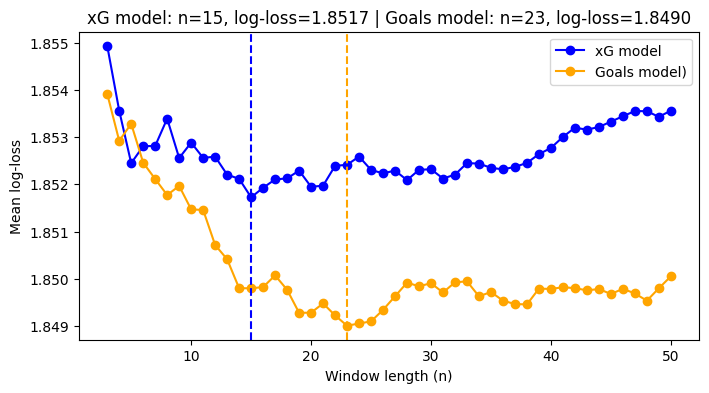

xG Rolling Average Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                13760
Model:                            GLM   Df Residuals:                    13756
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19872.
Date:                Wed, 11 Feb 2026   Deviance:                       15983.
Time:                        17:21:04   Pearson chi2:                 1.39e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03650
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.7

In [115]:
# Function to calculate rolling average feature for each match
def get_ma_variable(df, n, value_col, prefix):

    df = df.copy()

    # Calculate rolling averages for the attacking and defending team in both matches
    df[f"{prefix}_attack_mu"] = (df.groupby("attack_id")[value_col].transform(lambda s: s.shift(1).rolling(window=n, min_periods=1).mean()))
    df[f"{prefix}_defence_mu"] = (df.groupby("defence_id")[value_col].transform(lambda s: s.shift(1).rolling(window=n, min_periods=1).mean()))

    # Teams newly relegated into League 1 or newly promoted into League 2 have no data from the previous season
    # For this model they are assigned the global average (this is addressed later)
    avg_val = df[value_col].mean()
    df = df.sort_values(["season", "start"])
    df["attack_last_season"] = df.groupby("attack_id")["season"].transform(lambda s: s.shift(1).cummax())
    df["defence_last_season"] = df.groupby("defence_id")["season"].transform(lambda s: s.shift(1).cummax())
    attack_gap = df["season"] - df["attack_last_season"]
    defence_gap = df["season"] - df["defence_last_season"]
    df.loc[attack_gap > 1, f"{prefix}_attack_mu"] = np.nan
    df.loc[defence_gap > 1, f"{prefix}_defence_mu"] = np.nan
    df[f"{prefix}_attack_mu"] = df[f"{prefix}_attack_mu"].fillna(avg_val)
    df[f"{prefix}_defence_mu"] = df[f"{prefix}_defence_mu"].fillna(avg_val)
    df = df.drop(columns=["attack_last_season", "defence_last_season"])
    return df

# Tuning the optimal length of a rollig average window (n)
n_vals = np.arange(2, 50)
cv_results = []

for n in n_vals:

    fold_ll_xg = []
    fold_ll_goals = []

    # Create rolling average features over n
    df_tmp = model_df.copy()
    df_tmp = get_ma_variable(df_tmp, n, value_col="xg",    prefix="xg")
    df_tmp = get_ma_variable(df_tmp, n, value_col="goals", prefix="g")

    # Formula for Poisson regression
    formula_xg = "goals ~ home + xg_attack_mu + xg_defence_mu"
    formula_g = "goals ~ home + g_attack_mu  + g_defence_mu"

    # Loop through CV folds
    for train_seasons, test_season in cv_folds:

        # Create trian/test split
        train_df = df_tmp[df_tmp["season"].isin(train_seasons)]
        test_df = df_tmp[df_tmp["season"] == test_season].copy()

        # xG model
        m_xg = smf.glm(formula_xg, data=train_df, family=sm.families.Poisson()).fit()
        test_df["mu_pred_xg"] = m_xg.predict(test_df)
        match_df_xg = (test_df.groupby("match_id", as_index=False).agg(total_goals=("goals", "sum"), total_mu=("mu_pred_xg", "sum")))
        ll_xg = calc_log_loss(match_df_xg["total_goals"].astype(int).values,match_df_xg["total_mu"].values).mean()
        fold_ll_xg.append(ll_xg)

        # Goals model
        m_g = smf.glm(formula_g, data=train_df, family=sm.families.Poisson()).fit()
        test_df["mu_pred_g"] = m_g.predict(test_df)
        match_df_g = (test_df.groupby("match_id", as_index=False).agg(total_goals=("goals", "sum"), total_mu=("mu_pred_g", "sum")))
        ll_g = calc_log_loss(match_df_g["total_goals"].astype(int).values,match_df_g["total_mu"].values).mean()
        fold_ll_goals.append(ll_g)

    cv_results.append({"window_length": n+1, # match numbers start at 0
                       "mean_log_loss_xg": float(np.mean(fold_ll_xg)),
                       "mean_log_loss_goals": float(np.mean(fold_ll_goals)),})

# Store results in a dataframe
cv_df = pd.DataFrame(cv_results).sort_values("window_length").reset_index(drop=True)

# Store optimal n and the log-loss score for each model
optimal_n_xg = int(cv_df.loc[cv_df["mean_log_loss_xg"].idxmin(), "window_length"])
optimal_n_g = int(cv_df.loc[cv_df["mean_log_loss_goals"].idxmin(), "window_length"])
best_ll_xg = float(cv_df["mean_log_loss_xg"].min())
best_ll_g = float(cv_df["mean_log_loss_goals"].min())

# Plot the tuning curve to compare both models
plt.figure(figsize=(8, 4))
plt.plot(cv_df["window_length"], cv_df["mean_log_loss_xg"], marker="o", label="xG model", color="blue")
plt.plot(cv_df["window_length"], cv_df["mean_log_loss_goals"], marker="o", label="Goals model)", color="orange")
plt.axvline(optimal_n_xg, linestyle="--", color="blue")
plt.axvline(optimal_n_g, linestyle="--", color="orange")
plt.xlabel("Window length (n)")
plt.ylabel("Mean log-loss")
plt.title(f"xG model: n={optimal_n_xg}, log-loss={best_ll_xg:.4f} | "f"Goals model: n={optimal_n_g}, log-loss={best_ll_g:.4f}")
plt.legend()
plt.show()

# Refit optimal xG model
df_xg = model_df.copy()
df_xg = get_ma_variable(df_xg, optimal_n_xg, value_col="xg", prefix="xg")
train_xg = df_xg[df_xg["season"] <= 2024].copy()
final_model_xg = smf.glm("goals ~ home + xg_attack_mu + xg_defence_mu",data=train_xg, family=sm.families.Poisson()).fit()

# Refit optimal goal model
df_goals = model_df.copy()
df_goals = get_ma_variable(df_goals, optimal_n_g, value_col="goals", prefix="g")
train_goals = df_goals[df_goals["season"] <= 2024].copy()
final_model_g = smf.glm("goals ~ home + g_attack_mu + g_defence_mu",data=train_goals, family=sm.families.Poisson()).fit()

# Print model summary output to inspect coefficients
print("xG Rolling Average Model")
print(final_model_xg.summary())
print("Goals Rolling Average Model")
print(final_model_g.summary())


In a rolling average model, the results suggest that past goals are a better predictor of future goals than xG. The optimal window for xG is 15 games but for goals it is much longer - 23 games (roughly half a season). It is not surprising that the optimal window for goals is longer. Goals have higher variance than xG, and more data will be needed to find a true signal.

Comparing the summary output, both models equally weight home advantage and assign similar comparative weight to the attacking and defensive strength ratings.

### 3.2 Exponential Weighted Moving Average (EWMA) Model

In the optimal rolling average model, goals from 25 games ago are given equal importance to goals from the previous game. Intuitively, this does not feel right. More recent form is more predictive of future outcomes than form from several months ago.

To account for this, the exponential weighted average (EWMA) model computes a weighted rolling average, which assigns more value to recent matches than to matches far in the past. In this model, an exponential decay parameter, alpha, is tuned to find the optimal speed at which past matches should be discounted when predicting future goals. Again, this is a similar approach to Dixon and Coles (1997).

EWMA models are computed using both xG and goals.

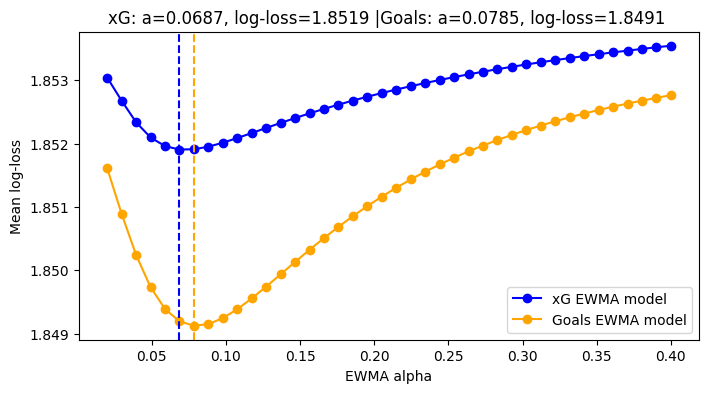

xG EWMA Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                13760
Model:                            GLM   Df Residuals:                    13756
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19890.
Date:                Wed, 11 Feb 2026   Deviance:                       16020.
Time:                        17:21:26   Pearson chi2:                 1.39e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.03394
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -0.7403      0.

In [116]:
# Function to calculate exponentially weighted moving average (EWMA) feature for each match
# This mirrors the structure for the rolling average
def get_ewma_variable(df, alpha, value_col, prefix):

    df = df.copy()

    df[f"{prefix}_attack_mu"] = (df.groupby("attack_id")[value_col].transform(lambda s: s.shift(1).ewm(alpha=alpha, adjust=False).mean()))
    df[f"{prefix}_defence_mu"] = (df.groupby("defence_id")[value_col].transform(lambda s: s.shift(1).ewm(alpha=alpha, adjust=False).mean()))

    avg_val = df[value_col].mean()
    df = df.sort_values(["season", "start"])
    df["attack_last_season"] = df.groupby("attack_id")["season"].transform(lambda s: s.shift(1).cummax())
    df["defence_last_season"] = df.groupby("defence_id")["season"].transform(lambda s: s.shift(1).cummax())
    attack_gap = df["season"] - df["attack_last_season"]
    defence_gap = df["season"] - df["defence_last_season"]
    df.loc[attack_gap > 1, f"{prefix}_attack_mu"] = np.nan
    df.loc[defence_gap > 1, f"{prefix}_defence_mu"] = np.nan
    df[f"{prefix}_attack_mu"] = df[f"{prefix}_attack_mu"].fillna(avg_val)
    df[f"{prefix}_defence_mu"] = df[f"{prefix}_defence_mu"].fillna(avg_val)
    df = df.drop(columns=["attack_last_season", "defence_last_season"])
    return df

# Tuning the optimal EWMA smoothing parameter (alpha)
alpha_vals = np.round(np.linspace(0.02, 0.4, 40), 4)
cv_results = []

for a in alpha_vals:

    fold_ll_xg = []
    fold_ll_goals = []

    # Create EWMA features over alpha
    df_tmp = model_df.copy()
    df_tmp = get_ewma_variable(df_tmp, a, value_col="xg",    prefix="xg")
    df_tmp = get_ewma_variable(df_tmp, a, value_col="goals", prefix="g")

    # Formula for Poisson regression
    formula_xg = "goals ~ home + xg_attack_mu + xg_defence_mu"
    formula_g = "goals ~ home + g_attack_mu  + g_defence_mu"

    # Loop through CV folds
    for train_seasons, test_season in cv_folds:

        # Create trian/test split
        train_df = df_tmp[df_tmp["season"].isin(train_seasons)]
        test_df = df_tmp[df_tmp["season"] == test_season].copy()

        # xG model
        m_xg = smf.glm(formula_xg, data=train_df, family=sm.families.Poisson()).fit()
        test_df["mu_pred_xg"] = m_xg.predict(test_df)
        match_df_xg = (test_df.groupby("match_id", as_index=False).agg(total_goals=("goals", "sum"), total_mu=("mu_pred_xg", "sum")))
        ll_xg = calc_log_loss(match_df_xg["total_goals"].astype(int).values, match_df_xg["total_mu"].values).mean()
        fold_ll_xg.append(ll_xg)

        # Goals model
        m_g = smf.glm(formula_g, data=train_df, family=sm.families.Poisson()).fit()
        test_df["mu_pred_g"] = m_g.predict(test_df)
        match_df_g = (test_df.groupby("match_id", as_index=False).agg(total_goals=("goals", "sum"), total_mu=("mu_pred_g", "sum")))
        ll_g = calc_log_loss(match_df_g["total_goals"].astype(int).values, match_df_g["total_mu"].values).mean()
        fold_ll_goals.append(ll_g)


    cv_results.append({"alpha": a,
                       "mean_log_loss_xg": float(np.mean(fold_ll_xg)),
                       "mean_log_loss_goals": float(np.mean(fold_ll_goals))})


# Store results in a dataframe
cv_df = pd.DataFrame(cv_results).sort_values("alpha").reset_index(drop=True)

# Store optimal alpha and the log-loss score for each model
optimal_a_xg = float(cv_df.loc[cv_df["mean_log_loss_xg"].idxmin(), "alpha"])
optimal_a_g = float(cv_df.loc[cv_df["mean_log_loss_goals"].idxmin(), "alpha"])
best_ll_xg = float(cv_df["mean_log_loss_xg"].min())
best_ll_g = float(cv_df["mean_log_loss_goals"].min())

# Plot the tuning curve to compare all models
plt.figure(figsize=(8, 4))
plt.plot(cv_df["alpha"], cv_df["mean_log_loss_xg"], marker="o", label="xG EWMA model", color="blue")
plt.plot(cv_df["alpha"], cv_df["mean_log_loss_goals"], marker="o", label="Goals EWMA model", color="orange")
plt.axvline(optimal_a_xg, linestyle="--", color="blue")
plt.axvline(optimal_a_g, linestyle="--", color="orange")
plt.xlabel("EWMA alpha")
plt.ylabel("Mean log-loss")
plt.title(f"xG: a={optimal_a_xg}, log-loss={best_ll_xg:.4f} |" f"Goals: a={optimal_a_g}, log-loss={best_ll_g:.4f} ")
plt.legend()
plt.show()

# Refit optimal xG EWMA model
df_xg = model_df.copy()
df_xg = get_ewma_variable(df_xg, optimal_a_xg, value_col="xg", prefix="xg")
train_xg = df_xg[df_xg["season"] <= 2024].copy()
final_model_xg = smf.glm("goals ~ home + xg_attack_mu + xg_defence_mu", data=train_xg, family=sm.families.Poisson()).fit()

# Refit optimal goal EWMA model
df_goals = model_df.copy()
df_goals = get_ewma_variable(df_goals, optimal_a_g, value_col="goals", prefix="g")
train_goals = df_goals[df_goals["season"] <= 2024].copy()
final_model_g = smf.glm("goals ~ home + g_attack_mu + g_defence_mu", data=train_goals, family=sm.families.Poisson()).fit()

# Print model summary output to inspect coefficients
print("xG EWMA Model")
print(final_model_xg.summary())
print("Goals EWMA Model")
print(final_model_g.summary())


In the EWMA model, goals also outperform xG. The mean log-loss is almost identical to the rolling-average model.

The optimal decay rates of 0.06875 and 0.0785 translate to past goals having a half-life of around 10 and 11 matches for the goals and xG models, respectively. A clear difference compared to the rolling average model is that, in the EWMA model, past goals are disregarded faster than xG (although the gap is very close). The exponential weighting smooths the moving average from game to game, creating a more stable feature, allowing past goals to provide a clear signal from a shorter window of past matches.

The increased stability of the EWMA model is reflected by the smoother tuning curve, which provides more confidence in identified minima in comparison to the rolling average example. Due to the increased stability and more intuitive realism, this EWMA model is carried forward into subsequent models.

### 3.3 Team Specific Home Advantage

The previous models consistently estimate a home advantage coefficient value of 0.19 (2d.p.). This implies that in any given match, a team will score ~21% more goals when they are playing at home. This home advantage is equally applied to all teams. In reality, home advantage will vary by team. For example, some teams get a huge boost from a loud and hostile home support, giving them a significant home advantage. Conversely, some teams have a counterattacking style, which is more suited to away matches and there is less variation between home and away form.

In this model, the general home advantage parameter is removed and EWMA values for attacking and defensive strength are made specific to home and away matches i.e., each team has four ratings at any given time.

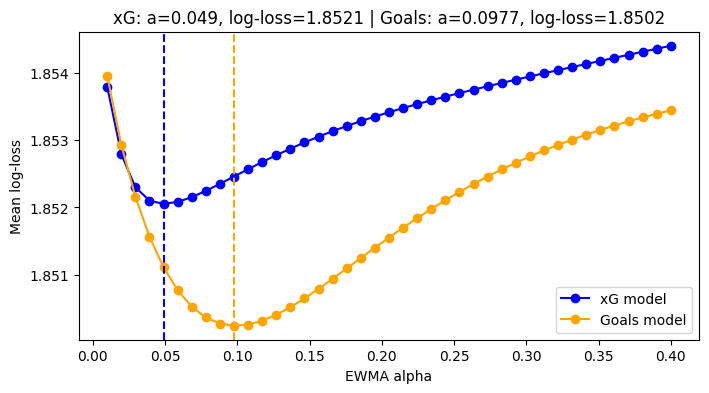

xG EWMA Home/Away (No explicit home term)
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                13760
Model:                            GLM   Df Residuals:                    13755
Model Family:                 Poisson   Df Model:                            4
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19970.
Date:                Wed, 11 Feb 2026   Deviance:                       16179.
Time:                        17:22:03   Pearson chi2:                 1.41e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.02269
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------

In [117]:
# Function to generate venue-specifc ewma variables
def get_ewma_home_away_variables(df, alpha, value_col, prefix):

    df = df.copy()

    # Calculate ewma variable for attacking and defending teams conditioned on playing home/away
    df[prefix + "_attack_mu_home"] = (df[df["home"] == 1].groupby("attack_id")[value_col].transform(lambda s: s.shift(1).ewm(alpha=alpha, adjust=False).mean()))
    df[prefix + "_attack_mu_away"] = (df[df["home"] == 0].groupby("attack_id")[value_col].transform(lambda s: s.shift(1).ewm(alpha=alpha, adjust=False).mean()))
    df[prefix + "_defence_mu_home"] = (df[df["home"] == 0].groupby("defence_id")[value_col].transform(lambda s: s.shift(1).ewm(alpha=alpha, adjust=False).mean()))
    df[prefix + "_defence_mu_away"] = (df[df["home"] == 1].groupby("defence_id")[value_col].transform(lambda s: s.shift(1).ewm(alpha=alpha, adjust=False).mean()))

    # Work out if teams are newly relegated to League 1 or promoted to League 2 and assign average values
    avg_val = df[value_col].mean()
    df = df.sort_values(["season", "start"])
    df["att_last_season_home"] = (df.loc[df["home"] == 1].groupby("attack_id")["season"].transform(lambda s: s.shift(1).cummax()))
    df["att_last_season_away"] = (df.loc[df["home"] == 0].groupby("attack_id")["season"].transform(lambda s: s.shift(1).cummax()))
    df["def_last_season_home"] = (df.loc[df["home"] == 0].groupby("defence_id")["season"].transform(lambda s: s.shift(1).cummax()))
    df["def_last_season_away"] = (df.loc[df["home"] == 1].groupby("defence_id")["season"].transform(lambda s: s.shift(1).cummax()))

    # Home assignment
    idx = df["home"] == 1
    gap = df.loc[idx, "season"] - df.loc[idx, "att_last_season_home"]
    df.loc[idx & (gap > 1), prefix + "_attack_mu_home"] = np.nan
    gap = df.loc[idx, "season"] - df.loc[idx, "def_last_season_away"]
    df.loc[idx & (gap > 1), prefix + "_defence_mu_away"] = np.nan

    # Away assignment
    idx = df["home"] == 0
    gap = df.loc[idx, "season"] - df.loc[idx, "att_last_season_away"]
    df.loc[idx & (gap > 1), prefix + "_attack_mu_away"] = np.nan
    gap = df.loc[idx, "season"] - df.loc[idx, "def_last_season_home"]
    df.loc[idx & (gap > 1), prefix + "_defence_mu_home"] = np.nan

    # Average values for teams with no data from the past season
    df[prefix + "_attack_mu_home"] = df[prefix + "_attack_mu_home"].fillna(avg_val)
    df[prefix + "_attack_mu_away"] = df[prefix + "_attack_mu_away"].fillna(avg_val)
    df[prefix + "_defence_mu_home"] = df[prefix + "_defence_mu_home"].fillna(avg_val)
    df[prefix + "_defence_mu_away"] = df[prefix + "_defence_mu_away"].fillna(avg_val)

    return df

# Tuning the optimal EWMA smoothing parameter (alpha)
alpha_vals = np.round(np.linspace(0.01, 0.4, 41), 4)
cv_results = []

for a in alpha_vals:

      # Create EWMA features for xG and goals
      df_a = model_df.copy()
      df_a = get_ewma_home_away_variables(df_a, a, value_col="xg",    prefix="xg")
      df_a = get_ewma_home_away_variables(df_a, a, value_col="goals", prefix="g")

      fold_ll_xg = []
      fold_ll_goals = []

      # Formula for Poisson regression
      formula_xg = "goals ~ xg_attack_mu_home + xg_attack_mu_away + xg_defence_mu_home + xg_defence_mu_away"
      formula_g = "goals ~ g_attack_mu_home  + g_attack_mu_away  + g_defence_mu_home  + g_defence_mu_away"

      # loop through train/test cross-validation
      for train_seasons, test_season in cv_folds:

            train_df = df_a[df_a["season"].isin(train_seasons)]
            test_df = df_a[df_a["season"] == test_season].copy()

            # xG model
            m_xg = smf.glm(formula=formula_xg, data=train_df, family=sm.families.Poisson()).fit()
            test_df["mu_pred_xg"] = m_xg.predict(test_df)
            match_df_xg = (test_df.groupby(["season","match_id"], as_index=False).agg(total_goals=("goals","sum"), total_mu=("mu_pred_xg","sum")))
            ll_xg = calc_log_loss(match_df_xg["total_goals"].astype(int).values,match_df_xg["total_mu"].values).mean()
            fold_ll_xg.append(ll_xg)

            # Goals model
            m_g = smf.glm(formula=formula_g, data=train_df, family=sm.families.Poisson()).fit()
            test_df["mu_pred_g"] = m_g.predict(test_df)
            match_df_g = (test_df.groupby(["season","match_id"], as_index=False).agg(total_goals=("goals","sum"), total_mu=("mu_pred_g","sum")))
            ll_g = calc_log_loss(match_df_g["total_goals"].astype(int).values, match_df_g["total_mu"].values).mean()
            fold_ll_goals.append(ll_g)

      cv_results.append({"alpha": a,
                         "mean_log_loss_xg": float(np.mean(fold_ll_xg)),
                         "mean_log_loss_goals": float(np.mean(fold_ll_goals))})


# Store results in a dataframe
cv_df = pd.DataFrame(cv_results).sort_values(["alpha"]).reset_index(drop=True)

# Store optimal alpha and the log-loss score for each model
optimal_a_xg = float(cv_df.loc[cv_df["mean_log_loss_xg"].idxmin(), "alpha"])
optimal_a_g = float(cv_df.loc[cv_df["mean_log_loss_goals"].idxmin(), "alpha"])
best_ll_xg = float(cv_df["mean_log_loss_xg"].min())
best_ll_g = float(cv_df["mean_log_loss_goals"].min())

# Plot the tuning curve to compare both models (alpha only)
plt.figure(figsize=(8, 4))
plt.plot(cv_df["alpha"], cv_df["mean_log_loss_xg"], marker="o", label=f"xG model", color="blue")
plt.plot(cv_df["alpha"], cv_df["mean_log_loss_goals"], marker="o", label=f"Goals model", color="orange")
plt.axvline(optimal_a_xg, linestyle="--", color="blue")
plt.axvline(optimal_a_g,  linestyle="--", color="orange")
plt.xlabel("EWMA alpha")
plt.ylabel("Mean log-loss")
plt.title(f"xG: a={optimal_a_xg}, log-loss={best_ll_xg:.4f} | " f"Goals: a={optimal_a_g}, log-loss={best_ll_g:.4f}")
plt.legend()
plt.show()

# Refit optimal xG EWMA Home/Away model (using optimal alpha)
df_xg = model_df.copy()
df_xg = get_ewma_home_away_variables(df_xg, optimal_a_xg, value_col="xg", prefix="xg")
train_xg = df_xg[df_xg["season"] <= 2024].copy()
final_formula_xg = "goals ~ xg_attack_mu_home + xg_attack_mu_away + xg_defence_mu_home + xg_defence_mu_away"
final_model_xg = smf.glm(final_formula_xg, data=train_xg, family=sm.families.Poisson()).fit()

# Refit optimal Goals EWMA Home/Away model (using optimal alpha)
df_goals = model_df.copy()
df_goals = get_ewma_home_away_variables(df_goals, optimal_a_g, value_col="goals", prefix="g")
train_goals = df_goals[df_goals["season"] <= 2024].copy()
final_formula_g = "goals ~ g_attack_mu_home + g_attack_mu_away + g_defence_mu_home + g_defence_mu_away"
final_model_g = smf.glm(final_formula_g, data=train_goals, family=sm.families.Poisson()).fit()

# Print model summary output to inspect coefficients
print("xG EWMA Home/Away (No explicit home term)")
print(final_model_xg.summary())
print("Goals EWMA Home/Away (No explicit home term)")
print(final_model_g.summary())


The model output and log-loss scores show that the team-specifc home advantage models are outperformed by the models which use a generic home advantage variable. Although this model is more realistic, the increased variance brought by dividing team strengths between home and away performances decreases prediction power across the CV test folds.

Based on this experiment, subsequent models will stick with the generic home-advantage parameter due to its superior out of sample performance.

###3.4 EWMA Goal Model with xG Shock



Over a window of 10+ matches, past goals appear to be better predictors of future goals than xG. xG is a more stable measure of attacking strength than goals, but it ignores finishing and shotstopping quality, and is less likely to predict high-scoring matches due to its lower variance.

However, over a shorter period of games, xG can often provide a better signal of attacking quality than goals due to the high variance of goals. xG might, therefore, be a better reflection of short-term form.

In this next model, a long-memory EWMA goals variable is used to provide a stable long-term rating of attacking and defensive quality whilst a short-memory EWMA calculated with xG values is used reflect the impact of more recent form on future goals.

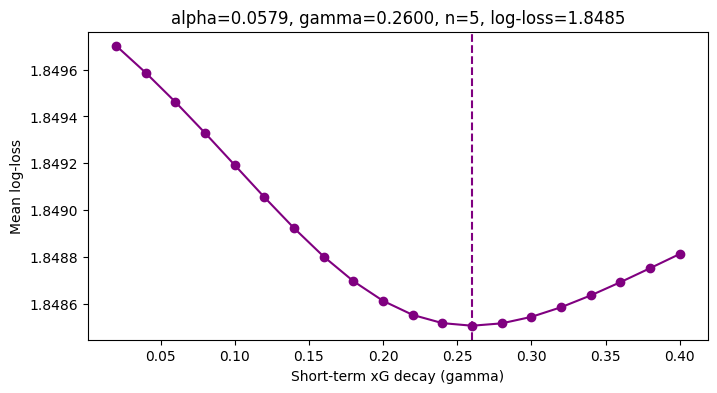

Goals EWMA + Short-term xG Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                13760
Model:                            GLM   Df Residuals:                    13754
Model Family:                 Poisson   Df Model:                            5
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19826.
Date:                Wed, 11 Feb 2026   Deviance:                       15892.
Time:                        18:03:57   Pearson chi2:                 1.38e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04287
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept    

In [118]:
""" LONG RUN TIME  """

# Function short-term xG form: EWMA over last n games (attack + defence)
def get_recent_xg_ewma_variable(df, gamma, n_games):

      df = df.copy()

      # Attacking team
      shifted_att = df.groupby("attack_id")["xg"].shift(1)
      df["recent_xg_att"] = (shifted_att.groupby(df["attack_id"]).rolling(window=n_games, min_periods=1)
                          .apply(lambda w: pd.Series(w).ewm(alpha=gamma, adjust=False).mean().iloc[-1], raw=False)
                          .reset_index(level=0, drop=True))

      # Defending team
      shifted_def = df.groupby("defence_id")["xg"].shift(1)
      df["recent_xg_def"] = (shifted_def.groupby(df["defence_id"]).rolling(window=n_games, min_periods=1)
                          .apply(lambda w: pd.Series(w).ewm(alpha=gamma, adjust=False).mean().iloc[-1], raw=False)
                          .reset_index(level=0, drop=True))

      # Filling in average values for newly promoted teams
      avg_val = df["xg"].mean()
      df = df.sort_values(["season", "start"])
      df["attack_last_season"] = df.groupby("attack_id")["season"].transform(lambda s: s.shift(1).cummax())
      df["defence_last_season"] = df.groupby("defence_id")["season"].transform(lambda s: s.shift(1).cummax())
      attack_gap = df["season"] - df["attack_last_season"]
      defence_gap = df["season"] - df["defence_last_season"]
      df.loc[attack_gap > 1, "recent_xg_att"] = np.nan
      df.loc[defence_gap > 1, "recent_xg_def"] = np.nan
      df["recent_xg_att"] = df["recent_xg_att"].fillna(avg_val)
      df["recent_xg_def"] = df["recent_xg_def"].fillna(avg_val)
      df = df.drop(columns=["attack_last_season", "defence_last_season"])
      return df


# Looping through to find optimal alpha and gamma values (decay speeds)
alpha_vals = np.round(np.linspace(0.02, 0.2, 20), 4)
gamma_vals = np.round(np.linspace(0.02, 0.4, 20), 4)

# window length for the short term effect is fixed at 5
n_vals = [5]
cv_results = []

# Loop through possible alpha
for a in alpha_vals:

      # Create EWMA features for goals (strength signal)
      df_a = model_df.copy()
      df_a = get_ewma_variable(df_a, a, value_col="goals", prefix="g")

      # Loop through possible gamma
      for gamma in gamma_vals:

            # Loop through possible window lengths
            for n_games in n_vals:

                  fold_ll = []
                  df_tmp = get_recent_xg_ewma_variable(df_a, gamma=gamma, n_games=int(n_games))
                  formula= "goals ~ home + g_attack_mu + g_defence_mu + recent_xg_att + recent_xg_def"

                  # Loop through train/test cross-validation
                  for train_seasons, test_season in cv_folds:

                        train_df = df_tmp[df_tmp["season"].isin(train_seasons)]
                        test_df = df_tmp[df_tmp["season"] == test_season].copy()

                        m = smf.glm(formula=formula, data=train_df, family=sm.families.Poisson()).fit()
                        test_df["mu_pred"] = m.predict(test_df)
                        match_df = (test_df.groupby(["season","match_id"], as_index=False).agg(total_goals=("goals","sum"), total_mu=("mu_pred","sum")))
                        ll = calc_log_loss(match_df["total_goals"].astype(int).values,match_df["total_mu"].values).mean()
                        fold_ll.append(ll)

                  cv_results.append({"alpha": float(a),
                                     "gamma": float(gamma),
                                     "n_games": int(n_games),
                                     "mean_log_loss": float(np.mean(fold_ll))})

# Store results
cv_df = pd.DataFrame(cv_results).sort_values(["alpha", "gamma", "n_games"]).reset_index(drop=True)

# Store optimal parameters for the model
best_idx = cv_df["mean_log_loss"].idxmin()
optimal_a = float(cv_df.loc[best_idx, "alpha"])
optimal_gamma = float(cv_df.loc[best_idx, "gamma"])
optimal_n = int(cv_df.loc[best_idx, "n_games"])
best_ll = float(cv_df.loc[best_idx, "mean_log_loss"])

# Filter results at model's optimal alpha
plot_df = cv_df[cv_df["alpha"] == optimal_a].copy().sort_values("gamma").reset_index(drop=True)

# Plot the gamma tuning curve
plt.figure(figsize=(8, 4))
plt.plot(plot_df["gamma"], plot_df["mean_log_loss"], marker="o", color="purple")
plt.axvline(optimal_gamma, linestyle="--", color="purple")
plt.xlabel("Short-term xG decay (gamma)")
plt.ylabel("Mean log-loss")
plt.title(f"alpha={optimal_a}, gamma={optimal_gamma:.4f}, n={optimal_n}, log-loss={best_ll:.4f}")
plt.show()

# Refit the optimal model
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma=float(optimal_gamma), n_games=int(optimal_n))
train = df[df["season"] <= 2024].copy()
optimal_formula = "goals ~ home + g_attack_mu + g_defence_mu + recent_xg_att + recent_xg_def"
optimal_model = smf.glm(optimal_formula, data=train, family=sm.families.Poisson()).fit()

# Print model summary output to inspect coefficients
print("Goals EWMA + Short-term xG Model")
print(optimal_model.summary())


The introduction of a short-memory xG term improves on both of the prior EWMA models, reducing mean log-loss from 1.8485. Further improvements in log-loss than this are likely achievable through further fine-tuning of the hyperparameters, but this is a very computationally expensive process.

Regarding the optimal values selected through this tuning: an alpha value of 0.0579 is very similar to the previous model and the gamma value of 0.26 means that matches 5 games ago account for less than 10% in the short-memory xG variable.

Due to an increase in predictive performance, this model is set as the baseline for further experiments.

###3.5 Promotion and Relegation Effects

Until this point, at the start of a new season, teams have been assigned attacking and defensive ratings based on matches from the prior season. This is justifiable when teams are competing in the same league as they were in the previous season. However, for newly promoted or relegated teams, at the start of a new season, their past performances are unlikely to be a strong predictor of future goals because the strength of their furture opponents changes.

To account for this, the model should adjust its goal predictions when teams have recently changed leagues. Due to the varying effects of promotion and relegation to and from Leagues 1 and 2 (see EDA), variables are made specifc to both leagues.

As a season progresses, the EWMA goal and xG variables become dominated by matches from the current season, gradually forgetting matches from the previous season. Therefore, it makes sense that the promotion and relegation adjustment should only be applied until we have sufficient evidence from the current season of how a team will perform in its new league.

In a similar way to how EWMA decays the effect of past matches, this model decays the impact of the promotion/relegation variable through a hyperparameter, epsillon. For the first game of the season, promotion and relegation variables are set to 1. As the season progresses the variables move to zero, allowing the model forget the promotion/relegation adjustments and focus only on recent form.

The optimal value of epsillon is tuned by fitting multiple models to the data to determine how quickly promotion and relegation effects should be forgotten.


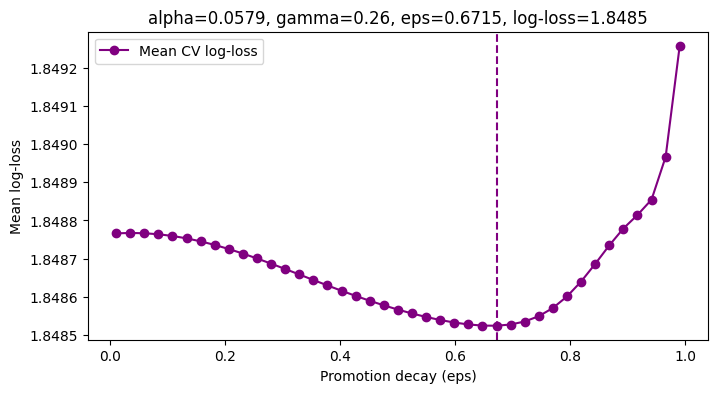

Promotion/Relegation Decay Model
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                13760
Model:                            GLM   Df Residuals:                    13746
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19817.
Date:                Wed, 11 Feb 2026   Deviance:                       15873.
Time:                        18:04:31   Pearson chi2:                 1.38e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.04416
Covariance Type:            nonrobust                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept  

In [119]:
# Function exponential promotion decay variable [0,1]
def get_promotion_decay_variable(df, eps):

    df = df.copy()
    w_att = np.power(eps, df["att_match_num"].to_numpy())
    w_def = np.power(eps, df["def_match_num"].to_numpy())
    att_cols = ["att_pro_L1","att_rel_L1","att_pro_L2","att_rel_L2"]
    def_cols = ["def_pro_L1","def_rel_L1","def_pro_L2","def_rel_L2"]

    for c in att_cols:
        df[c + "_eps"] = df[c].astype(int).to_numpy() * w_att
    for c in def_cols:
        df[c + "_eps"] = df[c].astype(int).to_numpy() * w_def
    return df


# fix on previously tuned alpha and gamma values
alpha = optimal_a
gamma = optimal_gamma
n_games = optimal_n
eps_vals = np.round(np.linspace(0.01, 0.99, 41), 4)
cv_results = []

# Create EWMA features for both signals (xG and Goals)
df = model_df.copy()
df = get_ewma_variable(df, alpha, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma = gamma, n_games=int(n_games))

# Loop through possible promotion decay rates
for eps in eps_vals:

      fold_ll = []
      df_eps = get_promotion_decay_variable(df, eps)
      promo_cols = [c + "_eps" for c in ["att_pro_L1","att_rel_L1","att_pro_L2","att_rel_L2","def_pro_L1","def_rel_L1","def_pro_L2","def_rel_L2"]]
      formula = "goals ~ home + g_attack_mu  + g_defence_mu + recent_xg_att + recent_xg_def + " + " + ".join(promo_cols)

      # Loop through train/test cross-validation
      for train_seasons, test_season in cv_folds:

            train_df = df_eps[df_eps["season"].isin(train_seasons)]
            test_df = df_eps[df_eps["season"] == test_season].copy()

            # Goals model
            m = smf.glm(formula=formula, data=train_df, family=sm.families.Poisson()).fit()
            test_df["mu_pred"] = m.predict(test_df)
            match_df = (test_df.groupby(["season","match_id"], as_index=False).agg(total_goals=("goals","sum"), total_mu=("mu_pred","sum")))
            ll = float(np.mean(calc_log_loss(match_df["total_goals"].astype(int).values,match_df["total_mu"].values)))
            fold_ll.append(ll)

      cv_results.append({"alpha": alpha,
                          "eps": float(eps),
                          "mean_log_loss": float(np.mean(fold_ll))})


# Store results in a dataframe
cv_df = pd.DataFrame(cv_results).sort_values(["alpha", "eps"]).reset_index(drop=True)

# Store optimal eps and the log-loss score for the model
optimal_eps = float(cv_df.loc[cv_df["mean_log_loss"].idxmin(), "eps"])
best_ll = float(cv_df["mean_log_loss"].min())

# Plot the tuning curve for epsillon
plt.figure(figsize=(8, 4))
plt.plot(cv_df["eps"], cv_df["mean_log_loss"], marker="o", color="purple", label="Mean CV log-loss")
plt.axvline(optimal_eps, linestyle="--", color="purple")
plt.xlabel("Promotion decay (eps)")
plt.ylabel("Mean log-loss")
plt.title(f"alpha={alpha}, gamma={gamma}, eps={optimal_eps:.4f}, log-loss={best_ll:.4f}")
plt.legend()
plt.show()

# Refit optimal model
df = model_df.copy()
df = get_ewma_variable(df, alpha, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma = gamma, n_games= n_games)
df = get_promotion_decay_variable(df, float(optimal_eps))
train_df = df[df["season"] <= 2024].copy()
promo_cols = [c + "_eps" for c in ["att_pro_L1","att_rel_L1","att_pro_L2","att_rel_L2","def_pro_L1","def_rel_L1","def_pro_L2","def_rel_L2"]]
final_formula = "goals ~ home + g_attack_mu + g_defence_mu + recent_xg_att + recent_xg_def +" + " + ".join(promo_cols)
final_model = smf.glm(final_formula, data=train_df, family=sm.families.Poisson()).fit()

# Print model summary output
print("Promotion/Relegation Decay Model")
print(final_model.summary())



Adding the promotion/relegation effects does not reduce the log loss any further than the pre-existing model. The optimal epsilon value of 0.6715 means that the promotion relegation effects are reducded to around 10% after 5 matches and become negligble by 10 matches.

The lack of improvement with these additional variables is likely a sample size issue. For example, only 2 teams per season are promoted to League 2. If the promotion effects only last for 10 matches, there are only 20 observations per season for the model to learn the effect of teams newly promoted to League 2. Moreover, across all CV folds, there are only 12 separate teams which are newly promoted to League 2. This instability is reflected in the model summary output, which shows that only 2 of the new variable coefficients are statistically significant at the 5% level.

###3.6 Additonal Covariate Optimisation

Given the limited scope of the dataset, past goals, past xG and promotion/relegation effects are likely to provide the greatest explanatory power compared to other variables. To test whether any other factors can increase the models' predictive capabilities, an exhaustive search looks for combinations of additional covariates which decrease the mean log-loss on the CV test folds.

In [120]:
# Additional covariates
features = ["features_no_crowds", "features_neutral_venue", "congestion_ad"]

results = []

# Function calculate log-loss on different model formulas
def eval_formula_mean_log_loss(df, formula):
    fold_log_loss = []
    for train_seasons, test_season in cv_folds:
        train_df = df[df["season"].isin(train_seasons)]
        test_df = df[df["season"] == test_season].copy()
        model = smf.glm(formula=formula,data=train_df,family=sm.families.Poisson()).fit()
        test_df["mu_pred"] = model.predict(test_df)
        match_df = (test_df.groupby(["season", "match_id"], as_index=False).agg(total_goals=("goals", "sum"),total_mu=("mu_pred", "sum")))
        log_loss = float(np.mean(calc_log_loss(match_df["total_goals"].astype(int).values,match_df["total_mu"].values)))
        fold_log_loss.append(log_loss)
    return float(np.mean(fold_log_loss))

# Create baseline features from latest model
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma = optimal_gamma, n_games=optimal_n)
df = get_promotion_decay_variable(df, float(optimal_eps))

# Ensure the new features are being added to the existing model
base_features = ["home", "g_attack_mu", "g_defence_mu", "recent_xg_att", "recent_xg_def"]
promo_features = [c + "_eps" for c in ["att_pro_L1","att_rel_L1","att_pro_L2","att_rel_L2","def_pro_L1","def_rel_L1","def_pro_L2","def_rel_L2"]]

# Initiate storing of best
best_score = np.inf
best_formula = None
best_combo = None

# Loop through different combinations of covariates
for k in range(len(features) + 1):
    for combo in combinations(features, k):

        # test formula
        rhs_terms = base_features + promo_features + list(combo)
        rhs = " + ".join(rhs_terms)
        formula = f"goals ~ {rhs}"
        score = eval_formula_mean_log_loss(df, formula)

        # store results if currently the best model
        if score < best_score:
            best_score = score
            best_formula = formula
            best_combo = combo

# refit the best formula
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma = optimal_gamma, n_games=optimal_n)
df = get_promotion_decay_variable(df, float(optimal_eps))
train_df = df[df["season"] <= 2024].copy()
final_poisson_model = smf.glm(formula=best_formula,data=train_df,family=sm.families.Poisson()).fit()

print(f"Best mean CV log-loss: {best_score:.6f}")
print(f"Best formula:\n{best_formula}\n")
print("Summary output for best combined model:\n")
print(final_model.summary())


Best mean CV log-loss: 1.848524
Best formula:
goals ~ home + g_attack_mu + g_defence_mu + recent_xg_att + recent_xg_def + att_pro_L1_eps + att_rel_L1_eps + att_pro_L2_eps + att_rel_L2_eps + def_pro_L1_eps + def_rel_L1_eps + def_pro_L2_eps + def_rel_L2_eps

Summary output for best combined model:

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  goals   No. Observations:                13760
Model:                            GLM   Df Residuals:                    13746
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -19817.
Date:                Wed, 11 Feb 2026   Deviance:                       15873.
Time:                        18:04:48   Pearson chi2:                 1.38e+04
No. Iterations:                     5   Pseudo R-squ. (CS):           

Following an exhaustive search of the remaining features, no additional covariates were added to the model, suggesting that they did not increase predictive power any further. Below, the final poisson model is refitted to extract predictions on the test sets within the CV. This will be used to evaluate and calibrate the model in Section 5.

In [121]:
# Recreating variables
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma=optimal_gamma, n_games=optimal_n)
df = get_promotion_decay_variable(df, float(optimal_eps))

test_match_pred = []

# Loop through CV folds
for train_seasons, test_season in cv_folds:
    train_df = df[df["season"].isin(train_seasons)].copy()
    test_df  = df[df["season"] == test_season].copy()

    # train the final poisson model on all folds and store the out-of-fold test predictions
    fold_model = smf.glm(formula=best_formula,data=train_df,family=sm.families.Poisson()).fit()
    test_df["mu_pred"] = fold_model.predict(test_df)
    test_df["cv_test_season"] = test_season
    test_df["cv_train_seasons_min"] = min(train_seasons)
    test_df["cv_train_seasons_max"] = max(train_seasons)
    keep_cols = ["match_id", "start", "season", "league","home", "attack_id", "defence_id", "attack", "defence",
                  "goals", "mu_pred","att_match_num", "def_match_num", "season_match_number",
                  "cv_test_season", "cv_train_seasons_min", "cv_train_seasons_max",]
    keep_cols = [c for c in keep_cols if c in test_df.columns]

    # add the fold prediictions to a composite dataset
    fold_match_df = get_matches_pred_df(test_df)
    fold_match_df["cv_test_season"] = test_season
    test_match_pred.append(fold_match_df)

# Final dataframe of all CV test predictions
test_poisson_pred = (pd.concat(test_match_pred, ignore_index=True).sort_values(["season", "start", "match_id"]).reset_index(drop=True))

##4. XGBoost Model

Compared to Poisson regression, XGBoost models are superior at modelling non-linear relationships between variables. To test whether this can generate a an improved predictive model, an XGBoost model is fitted using all of the available variables in the dataset. The hyperparameters are also tuned in a small search gird.

In [122]:
# Creating the EWMA variables tuned through the Poisson model
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma = optimal_gamma, n_games=optimal_n)
df = get_promotion_decay_variable(df, float(optimal_eps))

# Forming a list of feature cols
promo_cols = ["att_pro_L1","att_rel_L1","att_pro_L2","att_rel_L2","def_pro_L1","def_rel_L1","def_pro_L2","def_rel_L2"]
base_terms = ["home", "g_attack_mu", "g_defence_mu", "recent_xg_att", "recent_xg_def"]
features = ["features_no_crowds", "features_neutral_venue", "season_match_number", "congestion_ad"]
feature_cols = base_terms + features + promo_cols

# Setting up the hyperparameter search grid
param_grid = {"learning_rate": [0.03, 0.05],
              "max_depth": [3, 4],
              "min_child_weight": [1, 5],
              "n_estimators": [800, 1200],}

# Storing combinations of parameters
param_list = list(product(*param_grid.values()))
param_names = list(param_grid.keys())
results = []

# Looping through parameter list
for values in param_list:
    params = dict(zip(param_names, values))
    fold_log_loss = []

    # Looping through CV folds
    for train_seasons, test_season in cv_folds:

        train_df = df[df["season"].isin(train_seasons)]
        test_df  = df[df["season"] == test_season].copy()

        model = XGBRegressor(objective="count:poisson", eval_metric="poisson-nloglik",tree_method="hist",random_state=42, **params)
        model.fit(train_df[feature_cols], train_df["goals"])
        test_df["mu_pred"] = model.predict(test_df[feature_cols])
        match_df = (test_df.groupby(["season", "match_id"], as_index=False).agg(total_goals=("goals", "sum"),total_mu=("mu_pred", "sum")))
        log_loss = calc_log_loss(match_df["total_goals"].astype(int).values,match_df["total_mu"].values).mean()
        fold_log_loss.append(log_loss)

    results.append({"params": params,"mean_log_loss": np.mean(fold_log_loss)})

# Store results
results_df = pd.DataFrame(results).sort_values("mean_log_loss")
best = results_df.iloc[0]

# Print results
print(f"Optimal hyperparameters{best["params"]}")
print(f"Best mean log-loss {best["mean_log_loss"]}")

# refitting the best model
best_model = XGBRegressor(objective="count:poisson",eval_metric="poisson-nloglik",tree_method="hist",random_state=42,**best["params"])
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma = optimal_gamma, n_games=optimal_n)
train_df = df[df["season"] <= 2024].copy()
xgb_model = best_model.fit(train_df[feature_cols],train_df["goals"])
importance = (pd.DataFrame(best_model.get_booster().get_score(importance_type="gain").items(),
              columns=["feature", "gain"]).sort_values("gain", ascending=False))

# Print feature importances
print("Feature importance:")
print(importance)


Optimal hyperparameters{'learning_rate': 0.03, 'max_depth': 3, 'min_child_weight': 5, 'n_estimators': 800}
Best mean log-loss 1.860636697982364
Feature importance:
                   feature      gain
0                     home  9.844302
2             g_defence_mu  5.524275
1              g_attack_mu  4.492306
3            recent_xg_att  3.702173
10              att_rel_L1  3.487188
11              att_pro_L2  3.355022
4            recent_xg_def  2.821215
9               att_pro_L1  2.813396
13              def_pro_L1  2.501031
12              att_rel_L2  2.297728
14              def_rel_L1  2.258634
7      season_match_number  2.015327
8            congestion_ad  1.993377
15              def_pro_L2  1.874192
5       features_no_crowds  1.776017
16              def_rel_L2  1.702394
6   features_neutral_venue  1.514064


The XGBoost model does not improve the mean log-loss on the CV test sets, producing an average roughly 0.15 higher compared to the Poisson regression model.

The decreased performance is likely because XGBoost is a more flexible estimator whihch creates higher variances in output. Rather than finding the optimal goal distributions for either team, XGBoost focuses on the expectation (most likely outcome) which can lead to miscalibration on macthes with a higher goal expetancy.

As with the optimal Poisson regression model, the predictions on the CV test sets from the best XGBoost model are stored for further evaluation.

In [123]:
# Recreating variables
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma=optimal_gamma, n_games=optimal_n)
df = get_promotion_decay_variable(df, float(optimal_eps))

# Forming a list of feature cols (must match your XGBoost training code)
promo_cols = ["att_pro_L1","att_rel_L1","att_pro_L2","att_rel_L2","def_pro_L1","def_rel_L1","def_pro_L2","def_rel_L2"]
base_terms = ["home", "g_attack_mu", "g_defence_mu", "recent_xg_att", "recent_xg_def"]
features = ["features_no_crowds", "features_neutral_venue", "season_match_number", "congestion_ad"]
feature_cols = base_terms + features + promo_cols

test_match_pred = []

# Loop through CV folds
for train_seasons, test_season in cv_folds:
    train_df = df[df["season"].isin(train_seasons)].copy()
    test_df  = df[df["season"] == test_season].copy()

    # train the final xgboost model on all folds and store the out-of-fold test predictions
    fold_model = XGBRegressor(objective="count:poisson",eval_metric="poisson-nloglik",tree_method="hist",random_state=42,**best["params"],)
    fold_model.fit(train_df[feature_cols], train_df["goals"])
    test_df["mu_pred"] = fold_model.predict(test_df[feature_cols])
    test_df["cv_test_season"] = test_season
    test_df["cv_train_seasons_min"] = min(train_seasons)
    test_df["cv_train_seasons_max"] = max(train_seasons)
    keep_cols = ["match_id", "start", "season", "league","home", "attack_id", "defence_id", "attack", "defence",
                  "goals", "mu_pred","att_match_num", "def_match_num", "season_match_number",
                  "cv_test_season", "cv_train_seasons_min", "cv_train_seasons_max",]
    keep_cols = [c for c in keep_cols if c in test_df.columns]

    # add the fodl prediictions to a larger dataset
    fold_match_df = get_matches_pred_df(test_df)
    fold_match_df["cv_test_season"] = test_season
    test_match_pred.append(fold_match_df)

# Final dataframe of all CV test predictions
test_xgb_pred = (pd.concat(test_match_pred, ignore_index=True).sort_values(["season", "start", "match_id"]).reset_index(drop=True))

##5. Model Evaluation

This section will provide a more thorough evaluation of the best Poisson and XGBoost models up to this point.

To start with, the true distribution of total goals in the test set is compared to the predicted distribution of both models:

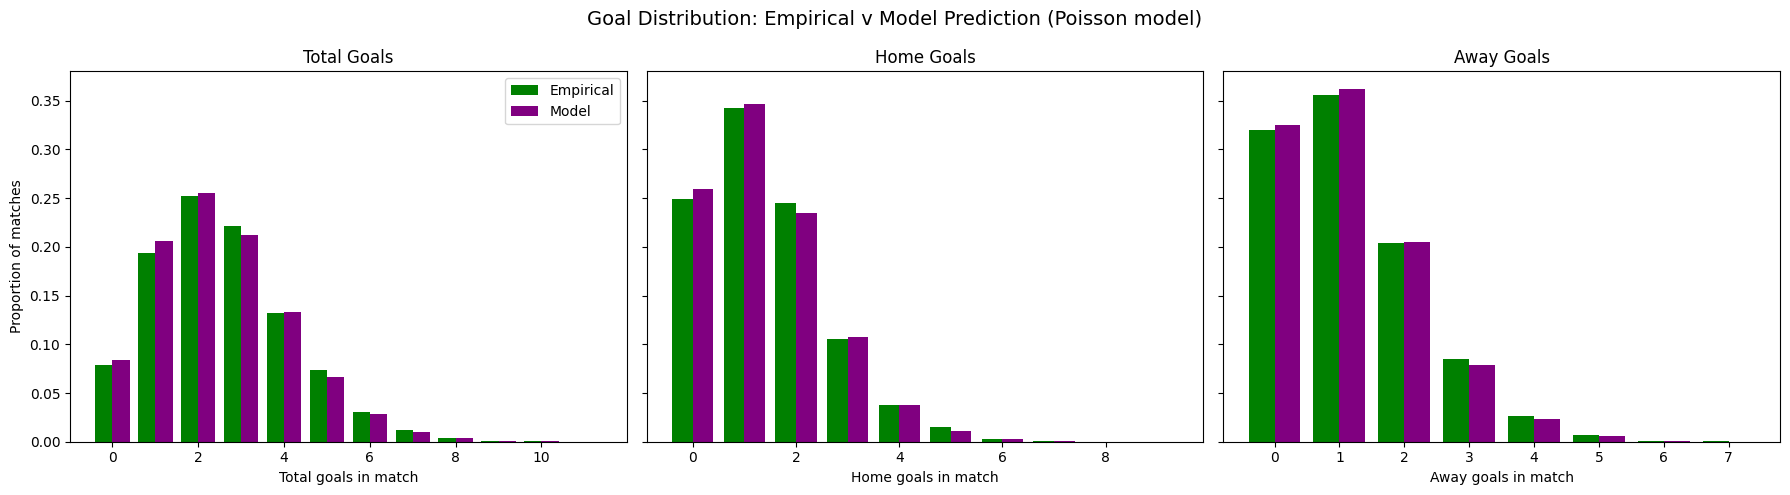

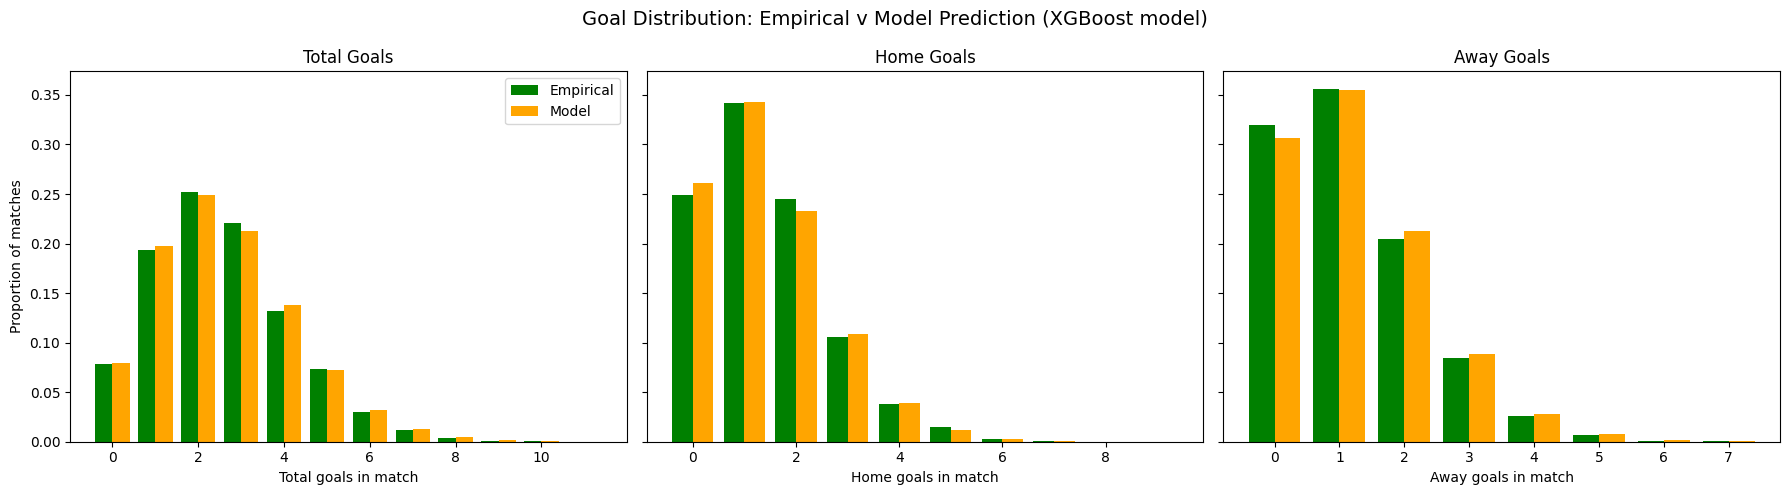

In [124]:
plot_goal_distributions(test_poisson_pred, "Poisson model", "purple")
plot_goal_distributions(test_xgb_pred, "XGBoost model", "orange")

These plots show that global distributions of both models produce a reasonable prediction, compared to the true outcomes. The Poisson regression model slightly overpredicts low-scoring matches and underpredicts high-scoring games. The opposite is true for the XGBoost model which underprecicts low scoring matches and overpredicts the likelihood of high-scoring games. From a global perspective, the similarity in distributions between both mdoels and the real observations suggests that they are well calibrated.



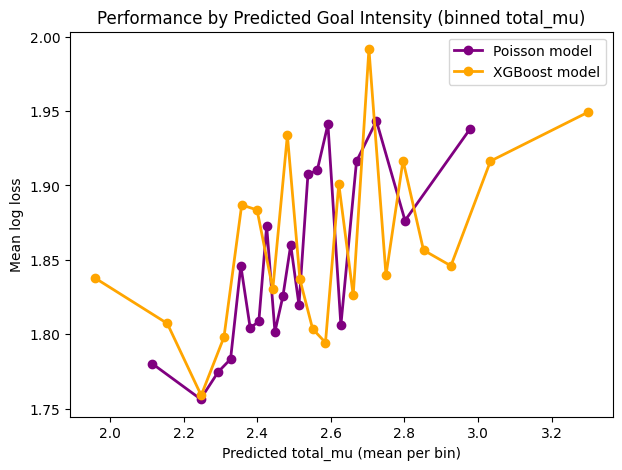

In [125]:
models = {"Poisson": {"matches_pred": test_poisson_pred, "model_name": "Poisson model", "color": "purple"},
          "goals": {"matches_pred": test_xgb_pred, "model_name": "XGBoost model", "color": "orange"}}
plot_log_loss_by_prediction(models)

The relationship between log-loss and the models' predicted expectation shows that both models perform best when they predict matches to produce 2.2 goals on average. The positive trend in both cases is expected, given that variance increases with goal expectation. The XGBoost model outperforms the Poisson model when they predict high-scoring matches and the converse is true for lower-scoring matches. Overall, XGBoost exhibits greater variance in performance, illustrating it's greater volatility compared to the Poisson model.

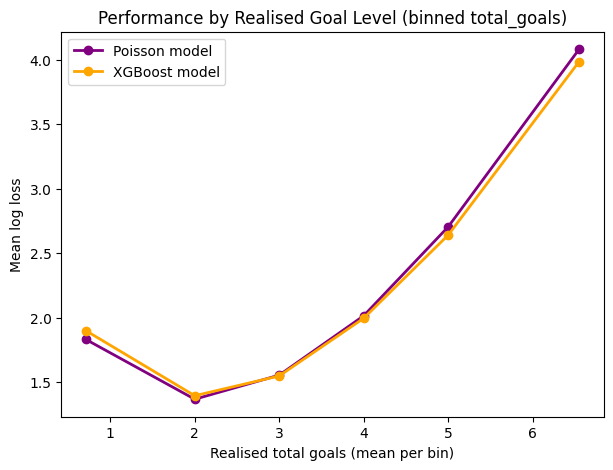

In [126]:
plot_log_loss_by_true_goals(models)

The relationship between log-loss and the true number of goals in a match reaffirms the same conclusions drawn from the previous plot. The Poisson model is superior for lower scoring matches but is out-performed in higher-scoring matches.

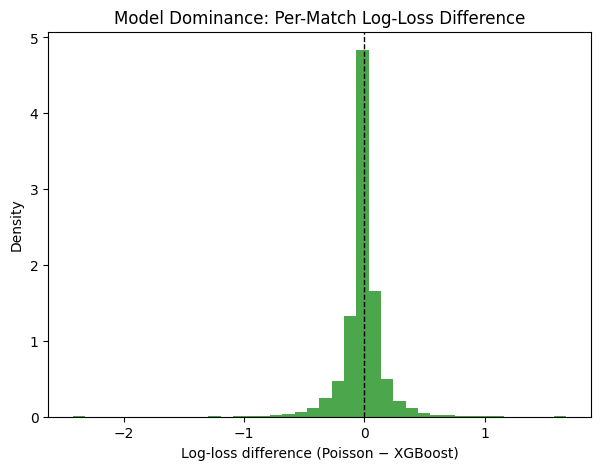

Poisson wins: 49.0%
XGBoost wins: 51.0%
Mean delta:  -0.0122


In [127]:
plot_dominance_diff(test_poisson_pred, test_xgb_pred)

Comparing both models on a per-match level shows that XGBoost beats the Poisson model prediction marginally more than it loses to it. Given that Poisson has a lower mean log-loss across all CV test folds, this suggests that when the XGBoost model loses, it does so by a bigger margin than when the Poisson model loses.

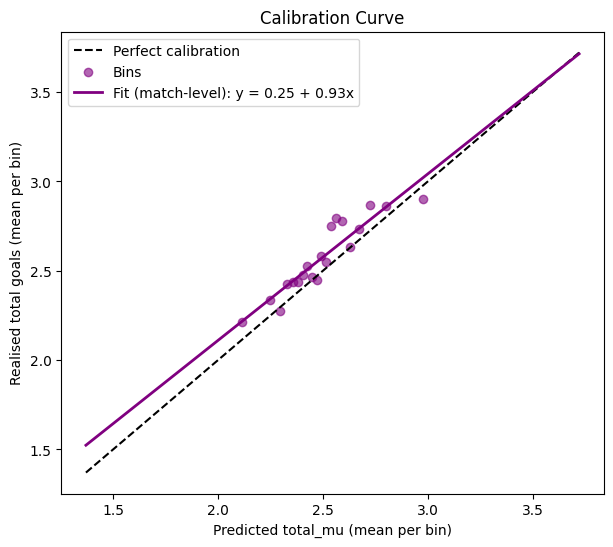

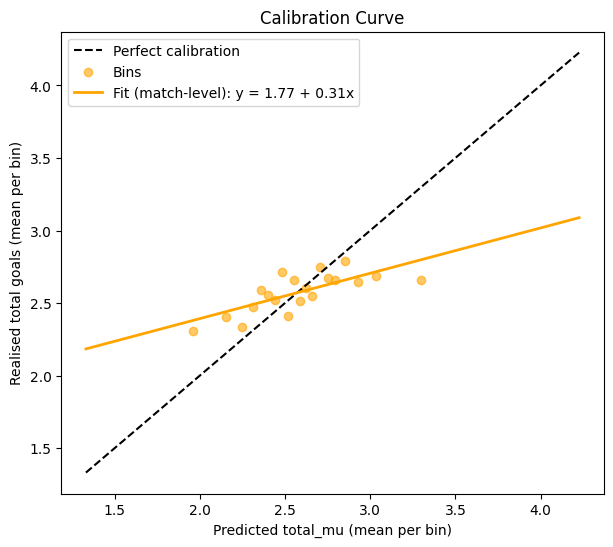

In [128]:
plot_calibration(test_poisson_pred, "purple")
plot_calibration(test_xgb_pred, "orange")

The calibration plots show that the Poisson regression model is already very well calibrated. With a positive intercept of 0.25, the model marginally underpredicts the total goals in a game on average. A gradient term of just less than 1, suggests that the model is slightly too overdispersed - predictions of low-scoring matches are too low and prediction of high scoring matches are too high.

The XGBoost model is significantly less well-calibrated. The high intercept term combined with a low gradient suggests that the model is overly compressed (reverting to the mean expectation too often). This leads to underpediction of high-scoring matches and over-prediction of low-scoring matches.

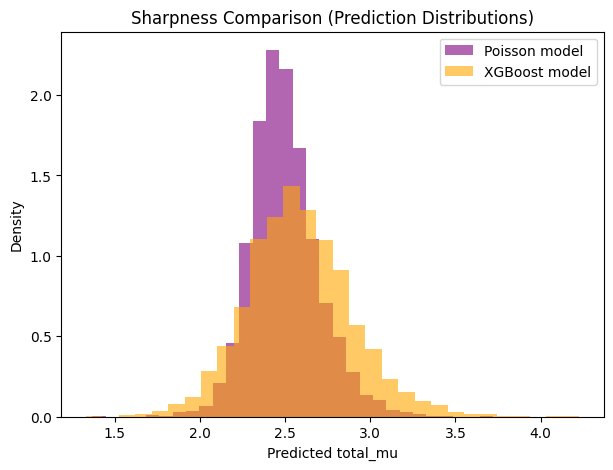

In [129]:
models = {"Poisson": {"matches_pred": test_poisson_pred, "model_name": "Poisson model", "color": "purple"},
          "goals": {"matches_pred": test_xgb_pred, "model_name": "XGBoost model", "color": "orange"}}
plot_prediction_hist(models)

The histogram above compares the distribution of expected values for both models across all test folds. The Poisson model had a noticeably sharper, more concentrated distribution than the XGBoost model which illustrates that the Poisson model is far more conservative than the XGBoost model. Predictions from the Poisson model rarely move far from a mean of roughly 2.5 goals per game. The distribution of the XGBoost model is far more dispersed, creating heavier tails which produce significantly more predictions with expectations wide of the mean.

The XGBoost model is more likely to make more extreme predictions than the Poisson model. This can produce high-performing log-loss scores on the per-match level but it cretaes a volatile, poorly calibrated model in general

In [130]:
calc_discrimination(test_poisson_pred)
calc_discrimination(test_xgb_pred)

Spearman correleation of observed goals and predicted goals: 0.108, (p-value: 3.97e-15)
Spearman correleation of observed goals and predicted goals: 0.055, (p-value: 6.156e-05)


The Spearman correlation coefficient informs how well the models discriminate between matches. More positive coefficient values imply that the model is better identifying which matches will produce more goals than others. Again, the Poisson model outperforms the XGBoost model by a clear margin, proving that it is better at identifying both high and low-scoring matches. This further supports the outcome of the calibration plots. Even though the correlation values are modest in size, they are both statistically significant, meaning that both models can order matches on based on how many goals they will produce, better than chance.

After a thorough evaluation of both models, the best model is clearly the Poisson regression model due to:

* superior mean log-loss on unsee CV test sets
* better calibration
* a higher discrimniation score

Given how well-calibrated the Poisson model already is, no post hoc calibration will be applied to prevent over-fitting the model to past data. The final section will provide a fair assessment of the Poisson model's performance, based on the held-out test set.

##6. External Validation

The final selected model is the Poisson regression model. Now that all training and has been completed, the choden model can be tested on the unseen seasons: 2024/25 and 2025/26 to provide an external validation of model performance which should provide a fair estimaion of model performance:

In [131]:
# Refitting the model on all CV folds
df = model_df.copy()
df = get_ewma_variable(df, optimal_a, value_col="goals", prefix="g")
df = get_recent_xg_ewma_variable(df, gamma=optimal_gamma, n_games=optimal_n)
df = get_promotion_decay_variable(df, float(optimal_eps))
train_df = df[df["season"] <= 2024].copy()
test_df  = df[df["season"] > 2024].copy()
final_poisson_model = smf.glm(formula=best_formula, data=train_df, family=sm.families.Poisson()).fit()

# Testing the model on the unseen data
test_df["mu_pred"] = final_poisson_model.predict(test_df)
final_poisson_pred = get_matches_pred_df(test_df)

# Calculate mean log-loss on
final_poisson_pred["log_loss"] = calc_log_loss(final_poisson_pred["total_goals"].astype(int).values, final_poisson_pred["total_mu"].values)
mean_log_loss = final_poisson_pred["log_loss"].mean()
print(f"Mean log-loss on unseen test data: {mean_log_loss:.6f}")

Mean log-loss on unseen test data: 1.831231


The mean log-loss on the unseen test data of 1.8312, is lower than the mean on the CV test folds. This is a positive signal as it suggests that the model has not been over-fitted to the data.

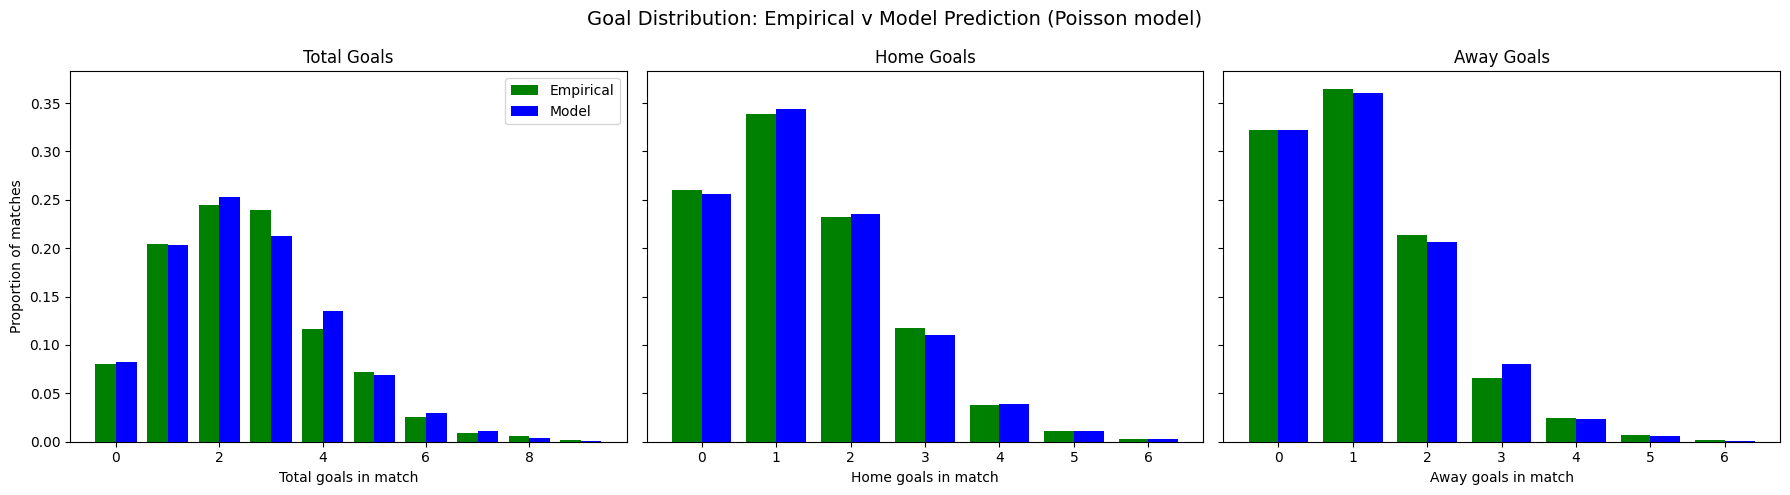

In [132]:
plot_goal_distributions(final_poisson_pred, "Poisson model", "blue")

Reproducing the global goal distribution shows a very similar match to the true distribution, signalling a broadly well-specified model.

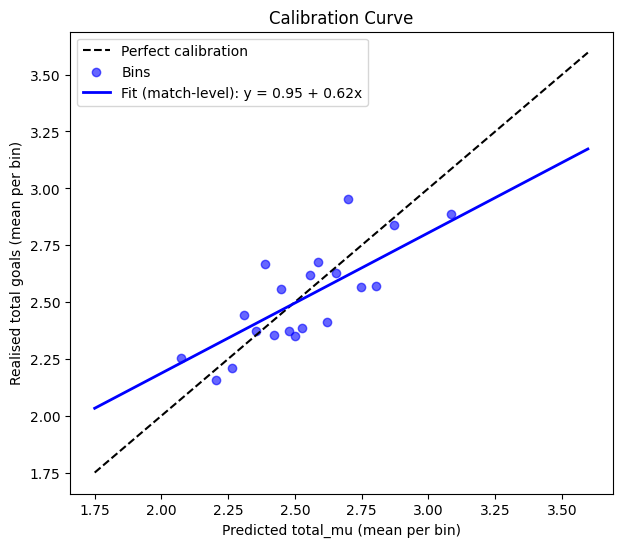

In [133]:
plot_calibration(final_poisson_pred, "blue")

The calibration curve shows a less well-calibrated model than in the training instance. The shallower slope and increased intercept illustrates an overdispersed model which tends to underprefict the total number of goals scored.

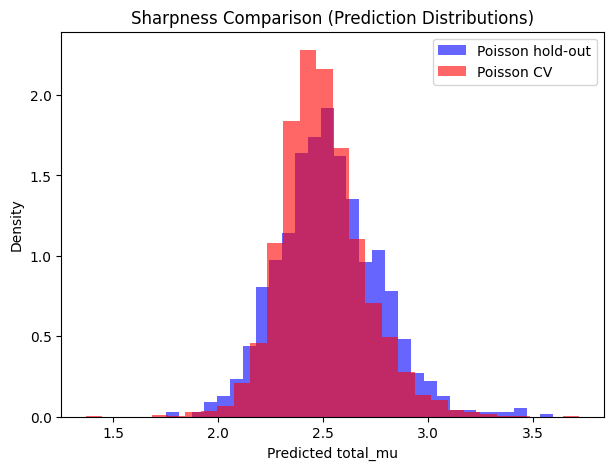

In [134]:
plot_prediction_hist({"Poisson hold-out": {"matches_pred": final_poisson_pred, "model_name": "Poisson hold-out", "color": "blue"},
                      "Poisson CV": {"matches_pred": test_poisson_pred, "model_name": "Poisson CV", "color": "red"}})

Comparing the sharpness of the model's prediction distributions on the CV test sets versus the held-out test set further illustrates the increased disperson and marginal underprediction when the model is applied to unseen data. This is also evidenced in the chart below, which shows the higher dispersion and volatility of performanc on the held-out test sets versus the CV test sets.

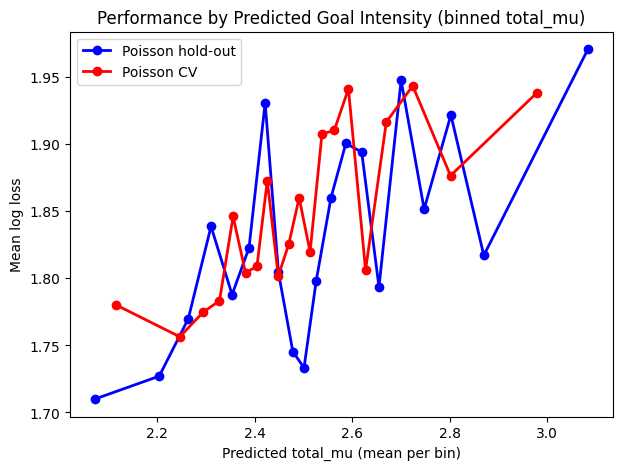

In [135]:
plot_log_loss_by_prediction({"Poisson Holdout": {"matches_pred": final_poisson_pred, "model_name": "Poisson hold-out", "color": "blue"},
                             "Poisson CV": {"matches_pred": test_poisson_pred, "model_name": "Poisson CV", "color": "red"}})

In [136]:
calc_discrimination(final_poisson_pred)
calc_discrimination(test_poisson_pred)

Spearman correleation of observed goals and predicted goals: 0.100, (p-value: 0.0004145)
Spearman correleation of observed goals and predicted goals: 0.108, (p-value: 3.97e-15)


Finally, the discrimination power of the model drops marginally on the unseen data but remains statistically significant, showing that the model has some ability to identify high and low-scoring matche.

Overall, the model generalises fairly well to the held-out test set and although performance drops slightly compared to performance on the CV test sets, the model is reasonably well-calibrated and can be deemed to have modest predictive power.

##7. Export Model Predictions

Saving the predictions of the final Poisson model on the unseen test set:

In [137]:
final_poisson_pred.to_csv("/content/drive/My Drive/Goal_Prediction_Model/data/model_predictions.csv")